# Accessing and displaying a sub-region of interest

Working with full Planet assets can be slow and cumbersome, which can create unnecessary overhead of you have a region of interest that is much smaller than the item footprint. Fortunately you can leverage [Cloud Optimized Geotiff](https://developers.planet.com/docs/planetschool/an-introduction-to-cloud-optimized-geotiffs-cogs-part-1-overview/) windowed reads to improve the speed of your Data API Asset Access workflow. Save storage and time by accessing only the pixels that you want to work with!

This notebook shows how to work with smaller regions of Planet assets available via the Data API. In this tutorial we will demonstrate how to:
* search for a Planet item with an area of interest (AOI)
* load data for the item within the bounds of the AOI
* visually display pixels within the AOI
* contrast stretch the visual display
* display NDVI within the AOI

If you are not familiar with the basics of the Data API, you may wish to start with the quickstart or another tutorial before going through this one.

## Setup

You will need a Planet API key, and some extra python dependencies to get started

#### Install python packages

In [ ]:
!pip install -q matplotlib numpy rasterio requests shapely pyproj

In [ ]:
import getpass
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pprint
from pyproj import Transformer
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
import requests
from shapely.geometry import Polygon, mapping, shape

In [ ]:
API_KEY = os.environ.get('PL_API_KEY')
if not API_KEY:
    API_KEY = getpass.getpass('Paste Planet API Key Here')

In [ ]:
# Setup a session
session = requests.Session()

# Authenticate
session.auth = (API_KEY, "")

# Set base URL for data api
URL = "https://api.planet.com/data/v1"

Let's ensure the API key is valid by making an item type GET request

In [ ]:
# API check
test_url = f'{URL}/item-types'
resp = session.get(test_url)
assert resp.ok, f'something seems wrong: {resp.status_code}, {resp.content}'
print("All set, let's go!")

## Search
First we will use the Data API search endpoint to find an item that intersects with our area of interest.
You can draw a custom AOI with a tool such as geojson.io

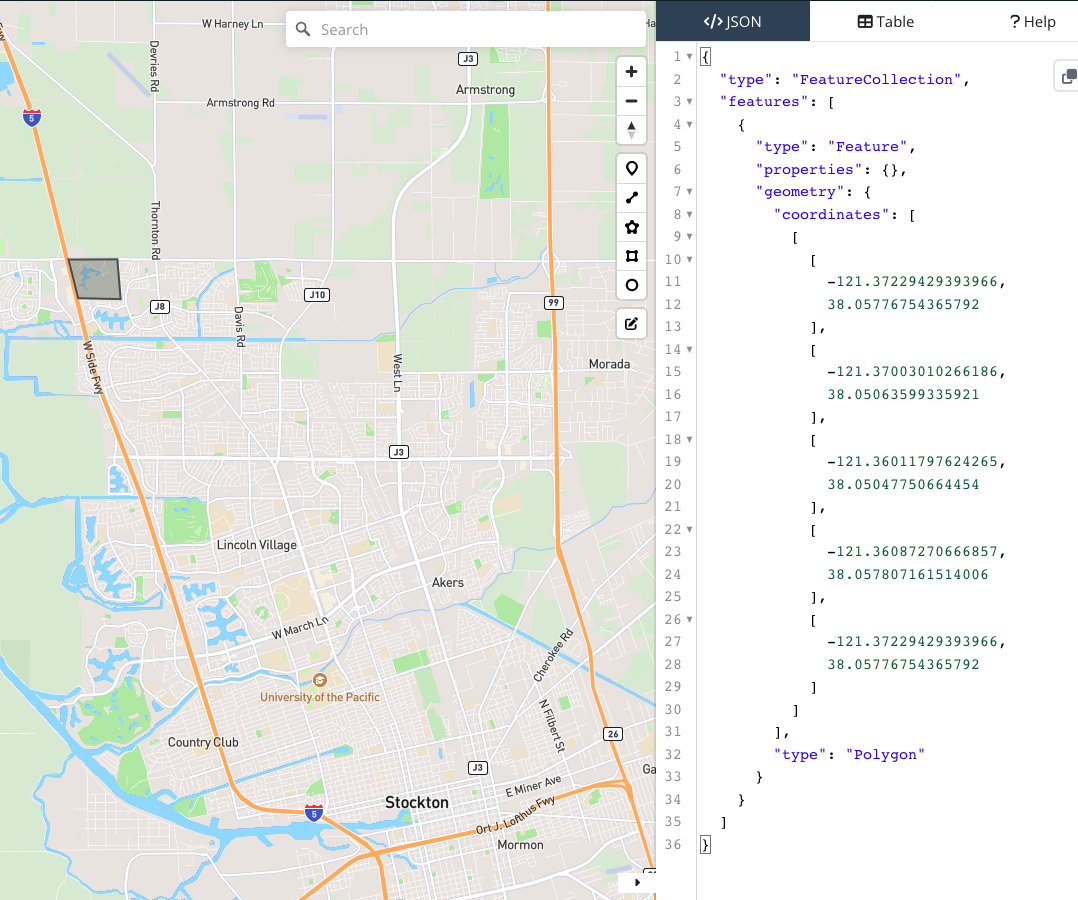

In [ ]:
# Oak Grove Park geometry drawn in geojson.io
geojson_geometry = {
    "coordinates": [
      [
        [
          -121.37229429393966,
          38.05776754365792
        ],
        [
          -121.37003010266186,
          38.05063599335921
        ],
        [
          -121.36011797624265,
          38.05047750664454
        ],
        [
          -121.36087270666857,
          38.057807161514006
        ],
        [
          -121.37229429393966,
          38.05776754365792
        ]
      ]
    ],
    "type": "Polygon"
  }

Additional **filters** to further constrain our Data API search

In [ ]:
# get images that overlap with our AOI 
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}

# get images acquired within a date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2016-08-31T00:00:00.000Z",
    "lte": "2016-09-01T00:00:00.000Z"
  }
}

# only get images which have <50% cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.5
  }
}

# combine our geo, date, cloud filters
combined_filter = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

run a search via an http request

In [ ]:
item_type = "PSScene"

# API request object
search_request = {
  "item_types": [item_type], 
  "filter": combined_filter
}

# fire off the POST request
search_result = \
  session.post(
    'https://api.planet.com/data/v1/quick-search',
    json=search_request)

results = search_result.json()

feat = results['features'][0]
pprint(feat)

In [ ]:
item_geom = feat['geometry']
item_id = feat['id']
asset = 'ortho_analytic_4b'
assert asset in feat['assets']

## Activate the asset of interest
The data API requires activating an item of interest before you can download or access the pixels.

In [ ]:
# check the activation status
assets_url = f'{URL}/item-types/{item_type}/items/{item_id}/assets'
resp = session.get(assets_url)
print(resp.json()[asset]['status'])

If the asset is not already in the active state, you can activate it with an http request. Activation is asyncronous and may take several minutes. You can poll for the asset status periodically.

In [ ]:
links = resp.json()[asset]["_links"]
activation_link = links["activate"]

# Request activation of the 'ortho_analytic_4b' asset:
activate_result = session.get(activation_link)

In [ ]:
while session.get(assets_url).json()[asset]['status'] != 'active':
    print(f"Asset Status: {session.get(assets_url).json()[asset]['status']}")
    time.sleep(15)

In [ ]:
# location key will appear after activation is complete
download_link = session.get(assets_url).json()[asset]['location']

## Read Data From AOI
Now that the asset is active, we can use a Cloud Optimized Geotiff windowed read to access just the region of interest within the asset. This way we do not need to download the entire scene but can access just the part we care about.

First, let's get the area of interest and the scene footprint as shapely shapes

In [ ]:
aoi_shape = shape(geojson_geometry)
aoi_shape

In [ ]:
item_shape = shape(item_geom)
item_shape

Note: If the aoi_shape is fully contained within the scene the clipped_shape will be identical to the aoi_shape

In [ ]:
clipped_shape = item_shape.intersection(aoi_shape)
clipped_shape

Notice that the clipped area can be much smaller than the full scene area. This means leveraging COG windowed reads can reduce overhead that would come from downloading the entire scene.

In [ ]:
print('full scene area:', item_shape.area)
print('clipped area:', clipped_shape.area)

We will visualize the clipped area below and should get a result similar to the displayed example image

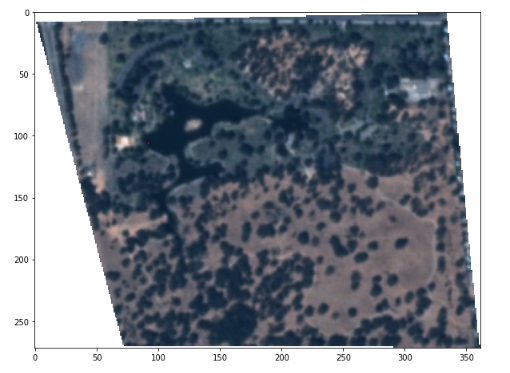

In [ ]:
# note: the download link expires eventually and you may need to re-fetch a fresh url using the asset "location" key above

# Open the COG
with rasterio.open(download_link) as src:
    
    # Create a transformer
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)

    # Transform the AOI to the dataset's CRS
    aoi_transformed = Polygon([transformer.transform(*coords) for coords in mapping(clipped_shape)["coordinates"][0]])
    
    # Get the bounds of the transformed AOI
    left, bottom, right, top = aoi_transformed.bounds
    
    # Convert the bounds to a rasterio window
    window = from_bounds(left, bottom, right, top, src.transform)
    
    # Read the data in the window
    data = src.read(window=window)
    
    # Mask the raster with the transformed AOI
    out_image, out_transform = mask(src, [mapping(aoi_transformed)], crop=True, filled=False)
    
    # Select the first three bands (BGR) and change the order to RGB
    rgb_image = out_image[:3][[2, 1, 0], :, :]
    
    # Normalize the pixel values to the range [0, 1]
    normalized_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
    
    # Apply a linear contrast stretch
    stretched_image = (normalized_image - np.min(normalized_image)) / (np.max(normalized_image) - np.min(normalized_image))
    
    # Replace the black background with white
    stretched_image[stretched_image == 0] = 1
    
    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(stretched_image.transpose([1, 2, 0]))

Since we leveraged a windowed read with a small AOI the above cell should be much faster than rendering the whole scene.

## Spectral Analysis
Since this example uses an analytic image, we don't just have to limit ourselves to visual RGB display. Let's do some bandmath with the red and NIR bands, to display a pseudo-NDVI. For real [NDVI](https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/) we would look up band specific metadata coefficients as described in other tutorials.

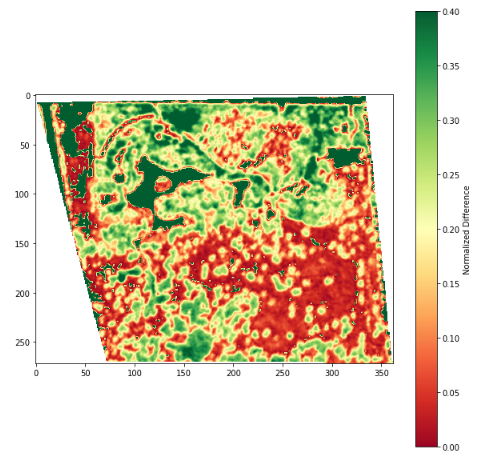

In [ ]:
# Open the COG
with rasterio.open(download_link) as src:
    # Create a transformer
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)

    # Transform the AOI to the dataset's CRS
    aoi_transformed = Polygon([transformer.transform(*coords) for coords in mapping(clipped_shape)["coordinates"][0]])

    # Mask the data with the transformed AOI
    out_image, out_transform = mask(src, [mapping(aoi_transformed)], crop=True, filled=False)
    
    # Read the Red and NIR bands from the masked image
    red_band = out_image[2]  # Red band
    nir_band = out_image[3]  # NIR band

# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)  # add a small constant to avoid division by zero

# Clip values to the range [0, 0.4]
ndvi = np.clip(ndvi, 0, 0.4)

# Plot NDVI
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='Normalized Difference')
plt.show()